Problem Statement
Develop a predictive model with at least 80% accuracy to determine the likelihood of a song entering the top 5 of a specific country's music charts within six months. This model will be based on a dataset comprising music-specific and country-specific features, utilizing machine learning algorithms and feature engineering techniques.

In [1]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Importing the song specific data from our raw_data folder:

In [2]:
songs_data = pd.read_csv('../raw_data/universal_top_spotify_songs.csv')

In [3]:
songs_data.head()

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",1,49,49,NaN,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499000,0.000006,0.0939,0.319,95.988,4
1,2GxrNKugF82CnoRFbQfzPf,i like the way you kiss me,Artemas,2,48,-1,NaN,2024-04-25,100,False,...,11,-4.263,1,0.0447,0.000938,0.010600,0.0826,0.747,151.647,4
2,2qSkIjg1o9h3YT9RAgYN75,Espresso,Sabrina Carpenter,3,47,4,NaN,2024-04-25,92,True,...,0,-5.486,1,0.0293,0.133000,0.000012,0.1970,0.661,103.982,4
3,6XjDF6nds4DE2BBbagZol6,Gata Only,"FloyyMenor, Cris Mj",4,46,-1,NaN,2024-04-25,98,True,...,8,-8.472,0,0.0509,0.446000,0.000024,0.0899,0.669,99.986,4
4,4q5YezDOIPcoLr8R81x9qy,I Can Do It With a Broken Heart,Taylor Swift,5,45,45,NaN,2024-04-25,84,True,...,0,-8.290,1,0.0513,0.147000,0.000000,0.1370,0.226,130.018,4


In [4]:
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683103 entries, 0 to 683102
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   spotify_id          683103 non-null  object 
 1   name                683078 non-null  object 
 2   artists             683078 non-null  object 
 3   daily_rank          683103 non-null  int64  
 4   daily_movement      683103 non-null  int64  
 5   weekly_movement     683103 non-null  int64  
 6   country             673896 non-null  object 
 7   snapshot_date       683103 non-null  object 
 8   popularity          683103 non-null  int64  
 9   is_explicit         683103 non-null  bool   
 10  duration_ms         683103 non-null  int64  
 11  album_name          682853 non-null  object 
 12  album_release_date  682853 non-null  object 
 13  danceability        683103 non-null  float64
 14  energy              683103 non-null  float64
 15  key                 683103 non-nul

The first step will be calculating the rate of missing values by Col

In [5]:
missing = pd.concat([songs_data.isnull().sum(), 100 * songs_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending = False)

,count,%
country,9207,1.347820
album_release_date,250,0.036598
album_name,250,0.036598
artists,25,0.003660
name,25,0.003660
key,0,0.000000
tempo,0,0.000000
valence,0,0.000000
liveness,0,0.000000
instrumentalness,0,0.000000


As we can see, country, album_relase_date, album_name, artist and name are the only columns with missing data. We will address these later in our analysis but first lets take a look at the values of categorical features:

In [6]:
# we will print the top values for the categorical variables in our dataset:
for var in songs_data.select_dtypes(include='object').columns:
    print("Column: " + var)
    print(songs_data[var].value_counts().head())
    print("\n")    

Column: spotify_id
spotify_id
3rUGC1vUpkDG9CZFHMur1t    7367
5mjYQaktjmjcMKcUIcqz4s    4626
1BxfuPKGuaTgP7aM0Bbdwr    4531
59NraMJsLaMCVtwXTSia8i    3879
56y1jOTK0XSvJzVv9vHQBK    3769
Name: count, dtype: int64


Column: name
name
greedy                                            7367
Strangers                                         4764
Cruel Summer                                      4531
One Of The Girls (with JENNIE, Lily Rose Depp)    3938
Prada                                             3879
Name: count, dtype: int64


Column: artists
artists
Taylor Swift     12361
Tate McRae        8377
Bad Bunny         6846
Ariana Grande     6271
KAROL G           6194
Name: count, dtype: int64


Column: country
country
DO    9475
IT    9474
NI    9470
UA    9464
PL    9464
Name: count, dtype: int64


Column: snapshot_date
snapshot_date
2024-03-16    3942
2023-11-20    3866
2024-03-18    3836
2024-03-14    3769
2023-10-27    3766
Name: count, dtype: int64


Column: album_name
album_name
nad

From the analysis of the variables we can infer a couple of things:<br>
    - need to convert column "snapshot_date" and "album_release_date" to dates<br>
    - Same song can be repeated multiple times in the dataset<br>
    - Need more information about the Country data (something seems to be wrong as the same count is repeated multiple times) <br><br>
The first thing we will do is converting to dates:

In [7]:
songs_data['snapshot_date'] = pd.to_datetime(songs_data['snapshot_date'])
songs_data['album_release_date'] = pd.to_datetime(songs_data['album_release_date'])
#confirm the new data types for the right columns:
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683103 entries, 0 to 683102
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   spotify_id          683103 non-null  object        
 1   name                683078 non-null  object        
 2   artists             683078 non-null  object        
 3   daily_rank          683103 non-null  int64         
 4   daily_movement      683103 non-null  int64         
 5   weekly_movement     683103 non-null  int64         
 6   country             673896 non-null  object        
 7   snapshot_date       683103 non-null  datetime64[ns]
 8   popularity          683103 non-null  int64         
 9   is_explicit         683103 non-null  bool          
 10  duration_ms         683103 non-null  int64         
 11  album_name          682853 non-null  object        
 12  album_release_date  682853 non-null  datetime64[ns]
 13  danceability        683103 no

In [8]:
songs_data['snapshot_date'].describe()

count                           683103
mean     2024-01-19 14:16:32.533190400
min                2023-10-18 00:00:00
25%                2023-12-03 00:00:00
50%                2024-01-19 00:00:00
75%                2024-03-06 00:00:00
max                2024-04-25 00:00:00
Name: snapshot_date, dtype: object

Before we tackle the full analysis of the data, we want to confirm the snapshot date covers the right amount of dates. from the previous analysis we can see that we are looking at song info from mid Oct 2023 to end of Apr 2024 (almost 6 months). <br><br>
Now that we have identified this, lets analyze the values for 'spotify_id'

In [9]:
songs_data[(songs_data['name'] == 'Fortnight (feat. Post Malone)')]['spotify_id'].value_counts()

spotify_id
2OzhQlSqBEmt7hmkYxfT6m    239
Name: count, dtype: int64

It looks like the spotify_id is unique for each song so we will use it going forward to identify each song

In [10]:
songs_data[(songs_data['spotify_id'] == '2OzhQlSqBEmt7hmkYxfT6m') & (songs_data['snapshot_date'] == '2024-04-25')]

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",1,49,49,NaN,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
58,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",9,41,41,ZA,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
101,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",2,0,48,VN,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
163,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",14,36,36,VE,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
220,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",21,1,29,UY,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
250,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",1,49,49,US,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
351,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",2,0,48,TW,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
466,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",17,1,33,TH,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
516,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",17,0,33,SV,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4
560,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),"Taylor Swift, Post Malone",11,2,39,SK,2024-04-25,90,False,...,11,-10.895,1,0.0245,0.499,0.000006,0.0939,0.319,95.988,4


The fact that there are seveal records per song on the same snapshot date implies that each record has a unique Country. so lets try revieweing it by country:

In [11]:
songs_data[(songs_data['spotify_id'] == '2OzhQlSqBEmt7hmkYxfT6m') & (songs_data['snapshot_date'] == '2024-04-25')]['country'].value_counts().head()

country
ZA    1
KR    1
IS    1
IL    1
IE    1
Name: count, dtype: int64

In [12]:
len(songs_data['spotify_id'].unique())

9810

<font color="#F22211"> It looks like each record represents a song in a country on a specific day! </font> for each song on each day we have valuable information like artist and album, the ranking in the country as well as changes daily and weekly and several song specific features. It also looks like we only have 9810 songs (definetly not the entirety of songs in the world).

Next we are going to take a look at one song on a specific date to see how all the other variables behave (using Describe):

In [13]:
songs_data[(songs_data['spotify_id'] == '2OzhQlSqBEmt7hmkYxfT6m') & (songs_data['snapshot_date'] == '2024-04-25')].describe().T

,count,mean,min,25%,50%,75%,max,std
daily_rank,58.0,12.5,1.0,2.25,9.0,20.5,42.0,11.40983
daily_movement,58.0,16.431034,-3.0,0.0,2.5,41.0,49.0,21.019717
weekly_movement,58.0,37.5,8.0,29.5,41.0,47.75,49.0,11.40983
snapshot_date,58,2024-04-25 00:00:00,2024-04-25 00:00:00,2024-04-25 00:00:00,2024-04-25 00:00:00,2024-04-25 00:00:00,2024-04-25 00:00:00,NaN
popularity,58.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0
duration_ms,58.0,228965.0,228965.0,228965.0,228965.0,228965.0,228965.0,0.0
album_release_date,58,2024-04-18 00:00:00,2024-04-18 00:00:00,2024-04-18 00:00:00,2024-04-18 00:00:00,2024-04-18 00:00:00,2024-04-18 00:00:00,NaN
danceability,58.0,0.675,0.675,0.675,0.675,0.675,0.675,0.0
energy,58.0,0.397,0.397,0.397,0.397,0.397,0.397,0.0
key,58.0,11.0,11.0,11.0,11.0,11.0,11.0,0.0


Once we isolate for a song/snapshot_date we can see the ranks and movements have a more normal behaviour. We also notice that popularity remains constant for the song/snapshotdate (which would indicate popularity worldwide) and all other features of the song remain constant across the same song/snapshot_date <br>
Next, lets create the column we want to predict, whether the song is or not in the top 5:

In [14]:
songs_data['top_5'] = songs_data['daily_rank'] <=5

Now, we want to start making decisions about the missing values, starting with the country field:

In [15]:
songs_data[songs_data['country'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9207 entries, 0 to 679511
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   spotify_id          9207 non-null   object        
 1   name                9207 non-null   object        
 2   artists             9207 non-null   object        
 3   daily_rank          9207 non-null   int64         
 4   daily_movement      9207 non-null   int64         
 5   weekly_movement     9207 non-null   int64         
 6   country             0 non-null      object        
 7   snapshot_date       9207 non-null   datetime64[ns]
 8   popularity          9207 non-null   int64         
 9   is_explicit         9207 non-null   bool          
 10  duration_ms         9207 non-null   int64         
 11  album_name          9204 non-null   object        
 12  album_release_date  9204 non-null   datetime64[ns]
 13  danceability        9207 non-null   float64       


It looks like the Nan country is a complete set of information (with no missing data). if we filter it out by a single date:

In [16]:
songs_data[(songs_data['country'].isnull()) & (songs_data['snapshot_date'] == '2024-04-25')]['spotify_id'].value_counts().head()

spotify_id
2OzhQlSqBEmt7hmkYxfT6m    1
62E2nR0od0M5HYxuYLaDz7    1
5bi0gh89wRuH2OgjdAKFsb    1
2h3MDMf8sd9s4XIzpTBIjX    1
3eh51r6rFWAlGQRlHx9QnQ    1
Name: count, dtype: int64

Our intuition was correct. the missing values of country are for world wide data. we can replace the values with 'Global'

In [17]:
songs_data.loc[songs_data['country'].isnull(), 'country'] = 'Global'

the next step of our analysis will take us to look at the distributions of the data we have. to do this we will use histograms for the data we have available:

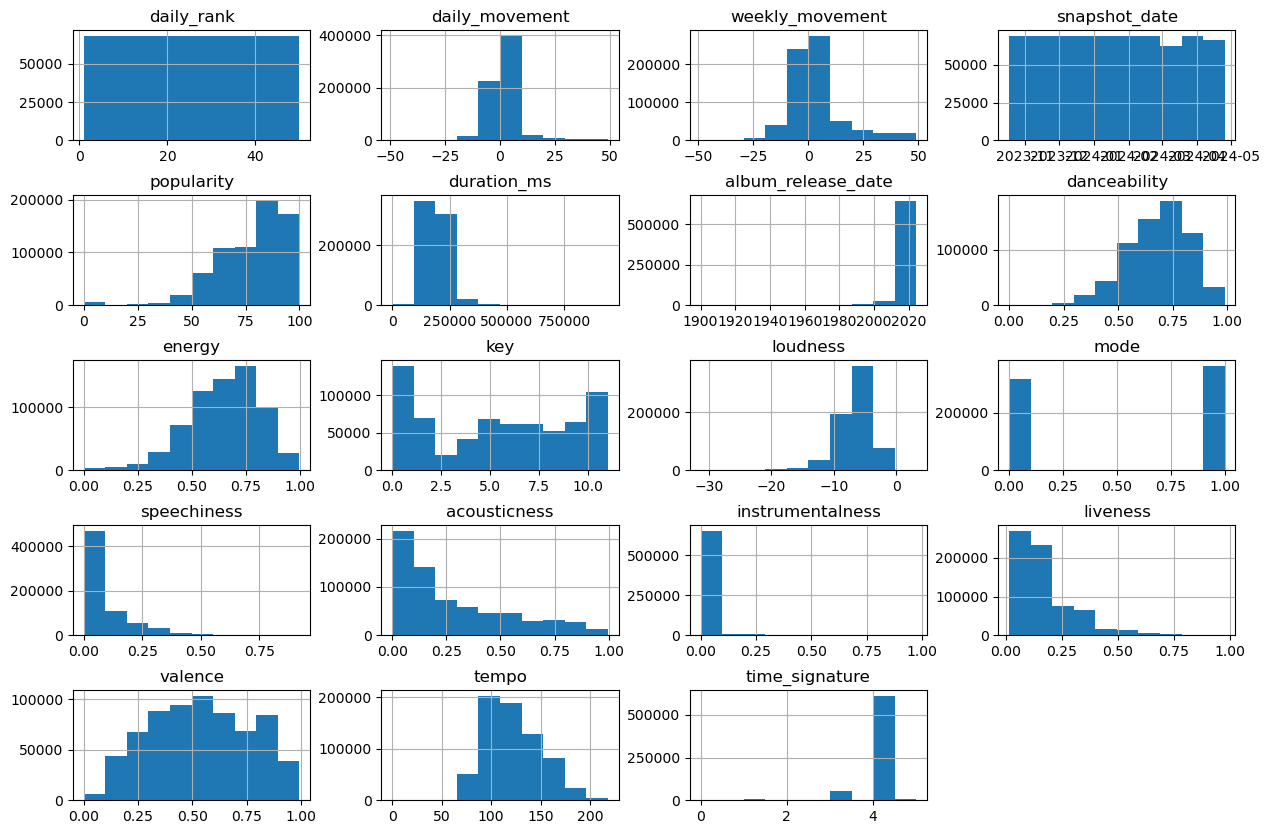

In [18]:
songs_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

Popularity seems to be the only distribution with a weird occurance of numbers around 0 so lets dig into this:

In [19]:
songs_data.loc[songs_data['popularity']<20, 'name'].value_counts()

name
yes, and?                         96
Style (Taylor's Version)          61
Fortnight (feat. Post Malone)     58
Blank Space (Taylor's Version)    55
The Tortured Poets Department     53
                                  ..
Ikaria                             1
Tvoje ruže                         1
Hoping For Life                    1
Untangled                          1
Birta                              1
Name: count, Length: 1963, dtype: int64

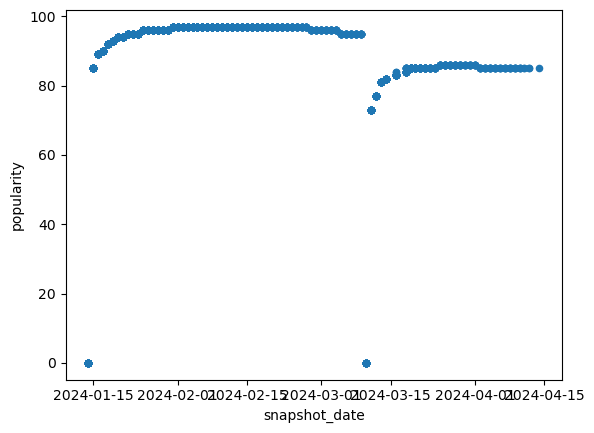

In [20]:
songs_data[songs_data['name'] == 'yes, and?'].plot.scatter(x = 'snapshot_date', y='popularity')
plt.show()

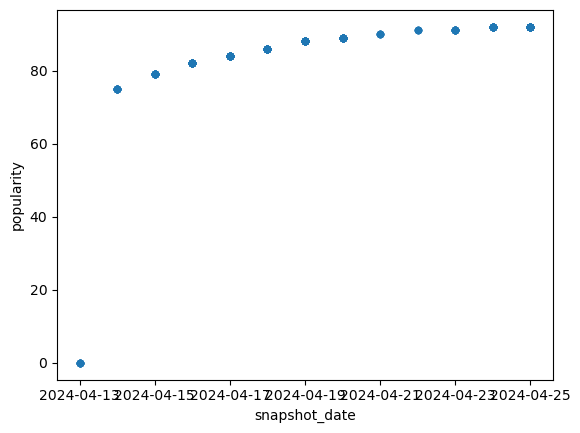

In [21]:
songs_data[songs_data['name'] == 'Espresso'].plot.scatter(x = 'snapshot_date', y='popularity')
plt.show()

When we look at the song with the most number of times ocurrance < 20 and compare this to a "normal" song from our set, we can see that the song "yes, and?" seems to have launched twice thus having a popularity of 0 more than once. To confirm this, lets look at the album release date:

In [22]:
songs_data.loc[(songs_data['name'] == 'yes, and?') & (songs_data['country'] == 'US'), ['snapshot_date','album_release_date']].sort_values('snapshot_date')

,snapshot_date,album_release_date
359028,2024-01-14,2024-01-12
355378,2024-01-15,2024-01-12
351737,2024-01-16,2024-01-12
348087,2024-01-17,2024-01-12
344437,2024-01-18,2024-01-12
340796,2024-01-19,2024-01-12
337149,2024-01-20,2024-01-12
333500,2024-01-21,2024-01-12
329850,2024-01-22,2024-01-12
326212,2024-01-23,2024-01-12


This information confirms our believes. it looks like this song was re launched on 03/08 after their originall launch on 01/12. We can either correct the popularity column and the relase date or keep it as it is. for the time being we will keep the information as the same song releasing twice. 

Now lets look at the missing values for album_release_date, album_name, artist and name:

In [23]:
songs_name_missing = songs_data.loc[songs_data['name'].isna(), 'spotify_id'].unique()
songs_data[songs_data['spotify_id'].isin(songs_name_missing)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 139937 to 680857
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   spotify_id          113 non-null    object        
 1   name                88 non-null     object        
 2   artists             88 non-null     object        
 3   daily_rank          113 non-null    int64         
 4   daily_movement      113 non-null    int64         
 5   weekly_movement     113 non-null    int64         
 6   country             113 non-null    object        
 7   snapshot_date       113 non-null    datetime64[ns]
 8   popularity          113 non-null    int64         
 9   is_explicit         113 non-null    bool          
 10  duration_ms         113 non-null    int64         
 11  album_name          88 non-null     object        
 12  album_release_date  88 non-null     datetime64[ns]
 13  danceability        113 non-null    float64    

In [24]:
for s in songs_name_missing:
    print('spotify_id: ' + s)
    print(len(songs_data.loc[songs_data['spotify_id'] == s, 'album_release_date'].unique()))
    print('\n')

spotify_id: 3vz3SKnCyJCzPuXWLoGfdG
1


spotify_id: 2h4b8QdmU4nxZrlpz7INIs
1


spotify_id: 2V2K1hzCtgj9xAnga9WUTy
2


spotify_id: 7lyv2sysHCzFjypILxAynT
1


spotify_id: 0kvD9ksvXyRHANPypIpkIh
1


spotify_id: 6yxtsR3nc3aUL1wcbLn8A3
2




as we can see from the data, the data missing is name, artists, album_name and album_release_date. iterating through the missing data we identify that only 2 out of the 6 songs with missing data have this info on other records, in this case we will get rid of the rows with NA on these columns.

In [25]:
songs_data.shape

(683103, 26)

In [26]:
songs_data.dropna(subset = ['name', 'artists', 'album_name', 'album_release_date'], inplace = True)
songs_data.shape

(682853, 26)

In [27]:
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682853 entries, 0 to 683102
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   spotify_id          682853 non-null  object        
 1   name                682853 non-null  object        
 2   artists             682853 non-null  object        
 3   daily_rank          682853 non-null  int64         
 4   daily_movement      682853 non-null  int64         
 5   weekly_movement     682853 non-null  int64         
 6   country             682853 non-null  object        
 7   snapshot_date       682853 non-null  datetime64[ns]
 8   popularity          682853 non-null  int64         
 9   is_explicit         682853 non-null  bool          
 10  duration_ms         682853 non-null  int64         
 11  album_name          682853 non-null  object        
 12  album_release_date  682853 non-null  datetime64[ns]
 13  danceability        682853 non-nul

Since the economic information has the countries names and the spotify data has 2 letter codes. We need to identify the codes with the countries. To do this we are pulling the list and standardizing:

In [28]:
country_codes = pd.read_csv('../raw_data/Country Data Codes.csv')

In [29]:
#lets only keep the column for the code information and re name the columns to standard names
country_codes = country_codes[['Name', 'ISO 3166']].rename(columns = {'Name' : 'name', 'ISO 3166' : 'code'})

In [30]:
country_codes.head()

,name,code
0,Afghanistan,AF|AFG|004
1,Akrotiri,-
2,Albania,AL|ALB|008
3,Algeria,DZ|DZA|012
4,American Samoa,AS|ASM|016


In [31]:
#clean up for missing values
country_codes.replace('-', np.nan, inplace = True)
country_codes.dropna(inplace=True)

In [32]:
#use the split text to identify the desired country code type
country_codes['code_standard'] = country_codes['code'].str.split('|', expand = True).loc[:,0]

In [33]:
country_codes['name'] = country_codes['name'].str.lower()

In [34]:
country_codes.drop(columns = ['code'], inplace = True)

In [35]:
country_codes.head()

,name,code_standard
0,afghanistan,AF
2,albania,AL
3,algeria,DZ
4,american samoa,AS
5,andorra,AD


After the data cleaning, we have a list of country codes that map the name to the code seen int he original data. The next step is combining our data sources with the socioeconomic indicators of interest for this analysis. First we are going to import the 'Country_data_1' File that has columns such as:
<ul>
<li>country :  Name of the country</li>
<li>child_mort :  Death of children under 5 years of age per 1000 live births</li>
<li>exports :  Exports of goods and services per capita. Given as %age of the GDP per capita</li>
<li>health :  Total health spending per capita. Given as %age of GDP per capita</li>
<li>imports :  Imports of goods and services per capita. Given as %age of the GDP per capita</li>
<li>Income :  Net income per person</li>
<li>Inflation :  The measurement of the annual growth rate of the Total GDP</li>
<li>life_expec :  The average number of years a new born child would live if the current mortality patterns are to remain the same</li>
<li>total_fer :  The number of children that would be born to each woman if the current age-fertility rates remain the same.</li>
<li>gdpp :  measurement of the annual growth rate of the GDP deflator</li>
</ul>

In [36]:
count_ind = pd.read_csv('../raw_data/Country_data_1.csv')
count_ind.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [37]:
count_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [38]:
#lower case the country name to be able to map to the code
count_ind['country'] = count_ind['country'].str.lower()
#merge on the country names
count_ind_temp = pd.merge(count_ind, country_codes, how = 'left', left_on = 'country', right_on = 'name')

In [39]:
# we want to see the list of countries that did not find a match so we can correct them:
count_ind_temp[count_ind_temp['name'].isna()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,name,code_standard
10,bahamas,13.8,35.000,7.89,43.7000,22900,-0.393,73.8,1.86,28000,NaN,NaN
30,cape verde,26.5,32.700,4.09,61.8000,5830,0.505,72.5,2.67,3310,NaN,NaN
37,"congo, dem. rep.",116.0,41.100,7.91,49.6000,609,20.800,57.5,6.54,334,NaN,NaN
38,"congo, rep.",63.9,85.100,2.46,54.7000,5190,20.700,60.4,4.95,2740,NaN,NaN
43,czech republic,3.4,66.000,7.88,62.9000,28300,-1.430,77.5,1.51,19800,NaN,NaN
56,gambia,80.3,23.800,5.69,42.7000,1660,4.300,65.5,5.71,562,NaN,NaN
83,kyrgyz republic,29.6,51.600,6.18,81.7000,2790,10.000,68.5,3.10,880,NaN,NaN
84,lao,78.9,35.400,4.47,49.3000,3980,9.200,63.8,3.15,1140,NaN,NaN
92,"macedonia, fyr",10.4,39.800,7.09,58.1000,11400,2.040,74.0,1.47,4540,NaN,NaN
101,"micronesia, fed. sts.",40.0,23.500,14.20,81.0000,3340,3.800,65.4,3.46,2860,NaN,NaN


In [40]:
#first we use the replace function to match the names in both files and then we will re run the matching:
count_ind['country'] = count_ind.country.replace({'bahamas':'bahamas, the', 'myanmar':'burma', 'cape verde':'cabo verde', 'congo, dem. rep.':'congo, democratic republic of the', 'czech republic':'czechia', 'gambia':'gambia, the', 'south korea':'korea, south', 'kyrgyz republic':'kyrgyzstan', 'lao':'laos', 'micronesia, fed. sts.':'micronesia, federated states of', 'macedonia, fyr':'north macedonia', 'st. vincent and the grenadines':'saint vincent and the grenadines', 'slovak republic':'slovakia', 'turkey':'turkey (turkiye)', 'congo, rep.':'congo, democratic republic of the' })
#merge on the country names
count_ind_temp = pd.merge(count_ind, country_codes, how = 'left', left_on = 'country', right_on = 'name')

In [41]:
# we want to see the list of countries that did not find a match so we can correct them:
count_ind_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        167 non-null    object 
 1   child_mort     167 non-null    float64
 2   exports        167 non-null    float64
 3   health         167 non-null    float64
 4   imports        167 non-null    float64
 5   income         167 non-null    int64  
 6   inflation      167 non-null    float64
 7   life_expec     167 non-null    float64
 8   total_fer      167 non-null    float64
 9   gdpp           167 non-null    int64  
 10  name           167 non-null    object 
 11  code_standard  167 non-null    object 
dtypes: float64(7), int64(2), object(3)
memory usage: 15.8+ KB


Now that all the countries have their respective codes, we can drop the name columns and keep only the relevant columns:

In [42]:
#dropping the unnecesary columns and re organizing to leave the country code in the 0 column
count_ind = count_ind_temp.drop(['country', 'name'], axis=1).reindex(['code_standard', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'], axis=1)

The second layer we want to add on top of this data is the religion data. In order to do this, we will import the GfG.csv file:

In [43]:
gfg = pd.read_csv('../raw_data/GfG.csv', index_col = 0)
gfg.head()

,country,chistians,muslims,unaffiliated,hindus,buddhists,folkReligions,other,jews,happinessRank,score,pop2021
0,Afghanistan,30000,31330000,5000,10000,5000,5000,20000,5000,153,2.567,39835428.0
1,Albania,580000,2570000,50000,5000,5000,5000,5000,5000,105,4.883,2872933.0
2,Algeria,60000,34730000,660000,5000,5000,10000,5000,5000,100,5.005,44616624.0
3,Argentina,34420000,400000,4920000,5000,20000,330000,120000,200000,55,5.975,45605826.0
4,Armenia,3050000,5000,40000,5000,5000,5000,5000,5000,116,4.677,2968127.0


As we can see above, the data is given in the totals per religion and the total sum of each religion is not exactly the same total shown in pop2021. Due to this, we need to create a temp column with the sum of all the religions per country so we can later use it to calculate the percentage per country for each religion:

In [44]:
#First we take the list of all the religions and add a new column for the total population based on the numbers for religion
religions = gfg.columns[1:-3]
gfg['tot_pop'] = gfg[religions].sum(axis=1)

In [45]:
#next we create a new column for each religion with the percentages of the total population for each religion
for r in religions:
    gfg[r+'_p'] = gfg[r]/gfg['tot_pop']
#we can drop the original columns with the qtys now that we have the percentages
gfg.drop(columns=religions, inplace = True)

Now that we have the percentages, we can compare the columns 'happinessRank' and 'Score' to identify if these are correlated:

In [46]:
np.corrcoef(gfg['happinessRank'],gfg['score'])

array([[ 1.        , -0.98528273],
       [-0.98528273,  1.        ]])

count    151.000000
mean      77.284768
std       44.472820
min        1.000000
25%       39.500000
50%       78.000000
75%      115.500000
max      153.000000
Name: happinessRank, dtype: float64


<Axes: >

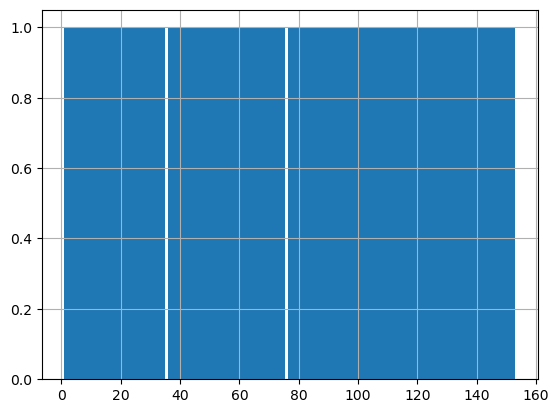

In [47]:
print(gfg['happinessRank'].describe())
gfg['happinessRank'].hist(bins = 153)

count    151.000000
mean       5.467430
std        1.117831
min        2.567000
25%        4.700500
50%        5.510000
75%        6.227500
max        7.809000
Name: score, dtype: float64


<Axes: >

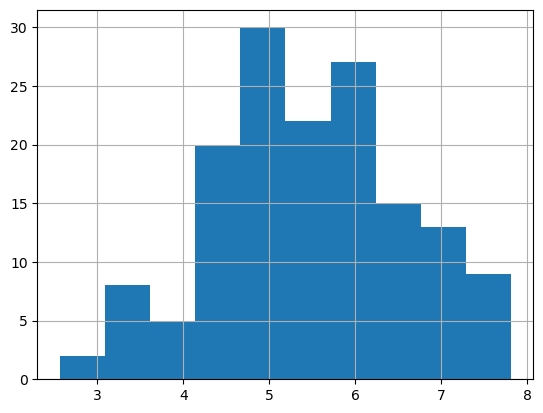

In [48]:
print(gfg['score'].describe())
gfg['score'].hist()

It looks like the happinessRank and the score are negatively correlated and the rank is distributed uniformly while the score follows what looks like a normal distribution. Since the distance in the rank could show more separation that the countries really have, we will use the score as the going metric.

Once we have removed the unnecesary columns, we can find the country code for these countries and fill them (just like we did earlier):

In [49]:
gfg.drop(columns=['happinessRank', 'tot_pop'], inplace = True)

In [50]:
gfg.head()

,country,score,pop2021,chistians_p,muslims_p,unaffiliated_p,hindus_p,buddhists_p,folkReligions_p,other_p,jews_p
0,Afghanistan,2.567,39835428.0,0.000955,0.997453,0.000159,0.000318,0.000159,0.000159,0.000637,0.000159
1,Albania,4.883,2872933.0,0.179845,0.796899,0.015504,0.001550,0.001550,0.001550,0.001550,0.001550
2,Algeria,5.005,44616624.0,0.001691,0.978861,0.018602,0.000141,0.000141,0.000282,0.000141,0.000141
3,Argentina,5.975,45605826.0,0.851664,0.009897,0.121737,0.000124,0.000495,0.008165,0.002969,0.004949
4,Armenia,4.677,2968127.0,0.977564,0.001603,0.012821,0.001603,0.001603,0.001603,0.001603,0.001603


In [51]:
#lower case the country name to be able to map to the code
gfg['country'] = gfg['country'].str.lower()
#merge on the country names
gfg_temp = pd.merge(gfg, country_codes, how = 'left', left_on = 'country', right_on = 'name')

In [52]:
gfg_temp[gfg_temp['name'].isna()].country

32            czech republic
35                  dr congo
44                    gambia
63               ivory coast
79                 macedonia
94                   myanmar
104                palestine
111    republic of the congo
123              south korea
127                swaziland
137                   turkey
Name: country, dtype: object

In [53]:
#first we use the replace function to match the names in both files and then we will re run the matching:
gfg['country'] = gfg.country.replace({'myanmar':'burma', 'dr congo':'congo, democratic republic of the', 'republic of the congo':'congo, republic of the', 'ivory coast':"cote d'ivoire", 'czech republic':'czechia', 'swaziland':'eswatini', 'gambia':'gambia, the', 'palestine':'gaza strip', 'south korea':'korea, south', 'macedonia':'north macedonia', 'turkey':'turkey (turkiye)'})
#merge on the country names
gfg_temp = pd.merge(gfg, country_codes, how = 'left', left_on = 'country', right_on = 'name')
gfg_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          151 non-null    object 
 1   score            151 non-null    float64
 2   pop2021          151 non-null    float64
 3   chistians_p      151 non-null    float64
 4   muslims_p        151 non-null    float64
 5   unaffiliated_p   151 non-null    float64
 6   hindus_p         151 non-null    float64
 7   buddhists_p      151 non-null    float64
 8   folkReligions_p  151 non-null    float64
 9   other_p          151 non-null    float64
 10  jews_p           151 non-null    float64
 11  name             151 non-null    object 
 12  code_standard    151 non-null    object 
dtypes: float64(10), object(3)
memory usage: 15.5+ KB


In [54]:
#renaming score to hap_score to be more clear
gfg_temp.rename(columns = {'score':'hap_score'}, inplace = True)

In [55]:
#merging with the original country DF so we can build a more complex DF
count_ind = pd.merge(count_ind, gfg_temp.drop(columns=['country', 'name']), how='inner', on='code_standard')
count_ind.head()

,code_standard,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,hap_score,pop2021,chistians_p,muslims_p,unaffiliated_p,hindus_p,buddhists_p,folkReligions_p,other_p,jews_p
0,AF,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2.567,39835428.0,0.000955,0.997453,0.000159,0.000318,0.000159,0.000159,0.000637,0.000159
1,AL,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,4.883,2872933.0,0.179845,0.796899,0.015504,0.001550,0.001550,0.001550,0.001550,0.001550
2,DZ,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,5.005,44616624.0,0.001691,0.978861,0.018602,0.000141,0.000141,0.000282,0.000141,0.000141
3,AR,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,5.975,45605826.0,0.851664,0.009897,0.121737,0.000124,0.000495,0.008165,0.002969,0.004949
4,AM,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,4.677,2968127.0,0.977564,0.001603,0.012821,0.001603,0.001603,0.001603,0.001603,0.001603


Now that we have the 2 country information dataframes combined, we can go ahead with merging our last layer that includes the region, human development index and gross national income per capita

In [56]:
gni = pd.read_csv('../raw_data/gross_national_income_per_capital.csv')
gni.head()

,ISO3,Country,hdicode,region,hdi_rank_2021,gnipc_1990,gnipc_1991,gnipc_1992,gnipc_1993,gnipc_1994,...,gnipc_2012,gnipc_2013,gnipc_2014,gnipc_2015,gnipc_2016,gnipc_2017,gnipc_2018,gnipc_2019,gnipc_2020,gnipc_2021
0,AFG,Afghanistan,Low,SA,180.0,2684.550019,2276.289409,2059.868084,1525.533426,1087.961890,...,2125.862821,2193.553936,2178.507021,2101.589319,2077.566899,2085.487571,2054.939895,2097.889450,1997.852149,1824.190915
1,AGO,Angola,Medium,SSA,148.0,4845.706901,5405.349257,2073.902390,2034.215197,1557.198363,...,7280.845666,7478.104777,7704.231949,7652.656486,7189.426672,6861.575738,6381.521946,6082.746624,5593.142060,5465.617791
2,ALB,Albania,High,ECA,67.0,4742.215529,3358.087827,3080.746654,3538.885493,3940.312045,...,11146.263030,11552.982470,11691.648290,12016.297600,12484.624200,12802.148310,13302.705960,13485.311240,12996.762910,14131.110390
3,AND,Andorra,Very High,NaN,40.0,43773.146500,43175.147600,41935.787200,40085.315890,39923.545880,...,47126.814610,46385.095200,48483.720320,49936.874540,52267.738320,52650.225760,53483.306630,54465.047400,47878.666640,51166.626610
4,ARE,United Arab Emirates,Very High,AS,26.0,102433.136000,96250.290360,93043.477370,92505.331100,96784.426940,...,57445.954750,60005.695360,62573.505310,65577.512240,66881.329740,67667.508460,67195.095230,68590.900940,63016.401220,62573.591810


In [57]:
#lets get rid of the historical income per capita and only keep the msot up to date data:
gni = gni[['ISO3', 'Country', 'hdicode', 'region', 'hdi_rank_2021','gnipc_2021']]

In [58]:
gni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ISO3           195 non-null    object 
 1   Country        206 non-null    object 
 2   hdicode        191 non-null    object 
 3   region         151 non-null    object 
 4   hdi_rank_2021  191 non-null    float64
 5   gnipc_2021     204 non-null    float64
dtypes: float64(2), object(4)
memory usage: 9.8+ KB


In [59]:
gni[gni.hdi_rank_2021.isna()]

,ISO3,Country,hdicode,region,hdi_rank_2021,gnipc_2021
108,MCO,Monaco,NaN,NaN,NaN,NaN
132,NRU,Nauru,NaN,EAP,NaN,17729.740840
142,PRK,Korea (Democratic People's Rep. of),NaN,EAP,NaN,NaN
158,SOM,Somalia,NaN,AS,NaN,1017.967850
195,NaN,Very high human development,NaN,NaN,NaN,43751.596460
196,NaN,High human development,NaN,NaN,NaN,15167.247710
197,NaN,Medium human development,NaN,NaN,NaN,6353.491965
198,NaN,Low human development,NaN,NaN,NaN,3009.120913
199,NaN,Arab States,NaN,NaN,NaN,13500.556150
200,NaN,East Asia and the Pacific,NaN,NaN,NaN,15580.436860


In [60]:
#as we could see, we can drop the NA rows for hdi
gni.dropna(subset=['hdicode'], inplace = True)
gni.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 194
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ISO3           191 non-null    object 
 1   Country        191 non-null    object 
 2   hdicode        191 non-null    object 
 3   region         148 non-null    object 
 4   hdi_rank_2021  191 non-null    float64
 5   gnipc_2021     191 non-null    float64
dtypes: float64(2), object(4)
memory usage: 10.4+ KB


In order to fill out the NAs in region, first we need to understand what regions and what countries are not mapped to a region:

In [61]:
#finding the spread of current regions mapped
gni.region.value_counts()

region
SSA    46
LAC    33
EAP    24
AS     19
ECA    17
SA      9
Name: count, dtype: int64

In [62]:
gni[gni.region.isna()]['Country']

3                     Andorra
8                   Australia
9                     Austria
12                    Belgium
16                   Bulgaria
29                     Canada
30                Switzerland
42                     Cyprus
43                    Czechia
44                    Germany
47                    Denmark
53                      Spain
54                    Estonia
56                    Finland
58                     France
61             United Kingdom
68                     Greece
72     Hong Kong, China (SAR)
74                    Croatia
76                    Hungary
79                    Ireland
82                    Iceland
83                     Israel
84                      Italy
87                      Japan
94        Korea (Republic of)
101             Liechtenstein
104                 Lithuania
105                Luxembourg
106                    Latvia
116                     Malta
129               Netherlands
130                    Norway
133       

it looks like most of the countries with no regions are located in europe with some north american and asian countries. Lets map it based on our knowledge:

In [63]:
#first we use the replace function to match the names in both files and then we will re run the matching:
gni['region'] = gni.region.replace({'Cyprus':'AS', 'Israel':'AS', 'Canada':'NA', 'United States':'NA', 'Australia':'EAP', 'Hong Kong, China (SAR)':'EAP', 'Japan':'EAP', 'Korea (Republic of)':'EAP', 'New Zealand':'EAP'})
gni.fillna('EU', inplace = True)

In [64]:
gni.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 194
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ISO3           191 non-null    object 
 1   Country        191 non-null    object 
 2   hdicode        191 non-null    object 
 3   region         191 non-null    object 
 4   hdi_rank_2021  191 non-null    float64
 5   gnipc_2021     191 non-null    float64
dtypes: float64(2), object(4)
memory usage: 10.4+ KB


In [65]:
#lower case the country name to be able to map to the code
gni['Country'] = gni['Country'].str.lower()
#merge on the country names
gni_temp = pd.merge(gni, country_codes, how = 'left', left_on = 'Country', right_on = 'name')
gni_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ISO3           191 non-null    object 
 1   Country        191 non-null    object 
 2   hdicode        191 non-null    object 
 3   region         191 non-null    object 
 4   hdi_rank_2021  191 non-null    float64
 5   gnipc_2021     191 non-null    float64
 6   name           169 non-null    object 
 7   code_standard  169 non-null    object 
dtypes: float64(2), object(6)
memory usage: 12.1+ KB


In [66]:
gni_temp[gni_temp.name.isna()][['ISO3','Country']]

,ISO3,Country
18,BHS,bahamas
22,BOL,bolivia (plurinational state of)
25,BRN,brunei darussalam
33,CIV,cã´te d'ivoire
35,COD,congo (democratic republic of the)
36,COG,congo
59,FSM,micronesia (federated states of)
65,GMB,gambia
72,HKG,"hong kong, china (sar)"
80,IRN,iran (islamic republic of)


In [67]:
#first we use the replace function to match the names in both files and then we will re run the matching:
gni['Country'] = gni.Country.replace({'bahamas':'bahamas, the', 'bolivia (plurinational state of)':'bolivia', 'brunei darussalam':'brunei', 'myanmar':'burma', 'congo (democratic republic of the)':'congo, democratic republic of the', 'congo':'congo, republic of the', "cã´te d'ivoire":"cote d'ivoire", 'eswatini (kingdom of)':'eswatini', 'gambia':'gambia, the', 'palestine, state of':'gaza strip', 'hong kong, china (sar)':'hong kong', 'iran (islamic republic of)':'iran', 'korea (republic of)':'korea, south', "lao people's democratic republic":'laos', 'micronesia (federated states of)':'micronesia, federated states of', 'moldova (republic of)':'moldova', 'russian federation':'russia', 'syrian arab republic':'syria', 'tanzania (united republic of)':'tanzania', 'tã¼rkiye':'turkey (turkiye)', 'venezuela (bolivarian republic of)':'venezuela', 'viet nam':'vietnam'})
#merge on the country names
gni_temp = pd.merge(gni, country_codes, how = 'left', left_on = 'Country', right_on = 'name')
gni_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ISO3           191 non-null    object 
 1   Country        191 non-null    object 
 2   hdicode        191 non-null    object 
 3   region         191 non-null    object 
 4   hdi_rank_2021  191 non-null    float64
 5   gnipc_2021     191 non-null    float64
 6   name           191 non-null    object 
 7   code_standard  191 non-null    object 
dtypes: float64(2), object(6)
memory usage: 12.1+ KB


In [68]:
#Now we can merge to the original country dataframe
count_ind = pd.merge(count_ind, gni_temp.drop(columns=['ISO3','Country', 'name']), how='inner', on='code_standard')
count_ind.head()

,code_standard,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,unaffiliated_p,hindus_p,buddhists_p,folkReligions_p,other_p,jews_p,hdicode,region,hdi_rank_2021,gnipc_2021
0,AF,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,...,0.000159,0.000318,0.000159,0.000159,0.000637,0.000159,Low,SA,180.0,1824.190915
1,AL,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,...,0.015504,0.001550,0.001550,0.001550,0.001550,0.001550,High,ECA,67.0,14131.110390
2,DZ,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,...,0.018602,0.000141,0.000141,0.000282,0.000141,0.000141,High,AS,91.0,10800.225460
3,AR,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,...,0.121737,0.000124,0.000495,0.008165,0.002969,0.004949,Very High,LAC,47.0,20925.268140
4,AM,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,...,0.012821,0.001603,0.001603,0.001603,0.001603,0.001603,High,ECA,85.0,13157.993900


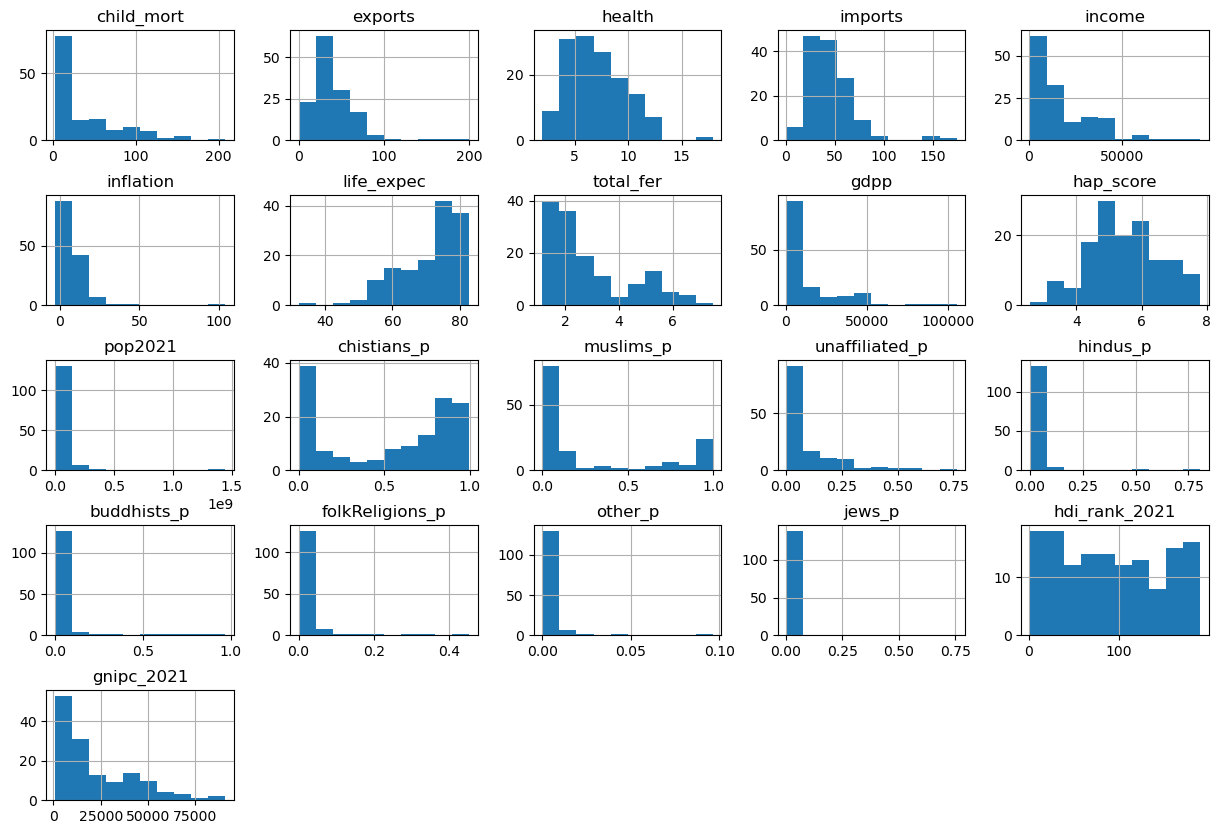

In [69]:
count_ind.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

It looks like our variables dont have surprising values. The only we one worth looking into is life_expec that seems to ahve a tail <40

In [70]:
count_ind[count_ind['life_expec']<40]

,code_standard,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,unaffiliated_p,hindus_p,buddhists_p,folkReligions_p,other_p,jews_p,hdicode,region,hdi_rank_2021,gnipc_2021
52,HT,208.0,15.3,6.91,64.7,1500,5.45,32.1,3.33,662,...,0.105788,0.000499,0.000499,0.021956,0.002994,0.000499,Low,LAC,163.0,2847.500746


From the looks of it, it looks like there is only one country with a fairly low life expectancy (32.1) and it is Haiti. This number is surprisingly low and with a quick google check it looks like this number is under estimated. we will replace it with 63.19 as this is the value provided in 2021 by the world bank.

In [71]:
count_ind.loc[count_ind['code_standard']=='HT','life_expec'] = 63.19

In [72]:
count_ind[['code_standard', 'life_expec']].head()

,code_standard,life_expec
0,AF,56.2
1,AL,76.3
2,DZ,76.5
3,AR,75.8
4,AM,73.3


For sanity, we reviewed the top values of the data set and found all of them close or the same than the most recent data provided by the world bank, so we can assume Haitin was a mistaken input that is now corrected.

Now that we have the country indicators, we can join them to the original dataset:

In [73]:
song_country_data = pd.merge(songs_data, count_ind, how = 'left', left_on = 'country', right_on = 'code_standard')

In [74]:
song_country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682853 entries, 0 to 682852
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   spotify_id          682853 non-null  object        
 1   name                682853 non-null  object        
 2   artists             682853 non-null  object        
 3   daily_rank          682853 non-null  int64         
 4   daily_movement      682853 non-null  int64         
 5   weekly_movement     682853 non-null  int64         
 6   country             682853 non-null  object        
 7   snapshot_date       682853 non-null  datetime64[ns]
 8   popularity          682853 non-null  int64         
 9   is_explicit         682853 non-null  bool          
 10  duration_ms         682853 non-null  int64         
 11  album_name          682853 non-null  object        
 12  album_release_date  682853 non-null  datetime64[ns]
 13  danceability        682853 no

In [75]:
#finding the countries missing socio economic data
song_country_data.loc[song_country_data['child_mort'].isna(), 'country'].unique()

array(['Global', 'TW', 'NI', 'MX', 'HN', 'HK'], dtype=object)

It looks like these 5 countries (except for "Global") were not included in all the socio economic indicators. as such we will remove them from the analysis and continue the analysis with the remaining countries as well as global. In order to do this we will drop these countries from our dataset:

In [76]:
song_country_data = song_country_data[~song_country_data['country'].isin(['TW', 'NI', 'MX', 'HN', 'HK'])]

In [77]:
#confirming that the only remaining N/A is the "Global" flag
song_country_data.loc[song_country_data['child_mort'].isna(), 'country'].unique()

array(['Global'], dtype=object)

Now that all data has been cleaned up and combined (with only the global records missing economic information). We can save the data in our files

In [78]:
# save the data to a new csv file`
song_country_data.to_csv('../data/songs_data_cleaned.csv')

Summary:

The data wrangling process took several steps.
<ul>
    <li>First we analyzed the spotify data and found very little missing values. made sense of the missing countries (as global values). and identified that each record represents a songs position on a given country on a specific date.</li>
    <li>We also identified that there are some songs that have been "relaunched" a couple of times, we decided to keep the data as it is for now and see how each re launch impacts the chances of the song to making it to the top 5.</li>
    <li>we finally identified records with name, album_name missing values and most of these had no feasible way to re construct (except for 2 records). Decided to drop all values with missing information (due to the very little impact to the overall dataset). </li>
    <li>Finally, we merged the economic indicators and the spotify data into a single dataset and saved it for further analysis.</li>
    <li>Compiled a list of ISO standard country codes to combine the socioeconomic DF with our Spotify data</li>
    <li>The first socioeconomic file included information such as Child mortaility, exports, health spending, imports, average net income per person, inflation, life expectancy, fertility rate and growe rate of gdp.</li>
    <li>the second socioeconomic file included information on the total population following the top religions (Christian, Muslim, Hindu...). It also included the 2021 population as well as the happines score. This was merged with the first socioeconomic file.</li>
    <li>The final DF included information such as the gross national income per capita, the human development index and the region for each country. this DF was combined with the original 2 to make a final count_ind DF with all the socioeconomic indicators of interest for the countries.</li>
    <li>Lastly we reviewed the distributions of these indicators and found most of them to behave in a normal or uniform distribution and had to do minimal cleanup.</li>
    <li>Finally we merged the songs and country DFs and saved the data as song_country_data to be used on the next stages</li>
</ul>